# Imports

In [1]:
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

Looking in links: ./
Processing /kaggle/input/kerasapplications/keras-team-keras-applications-3b180cb
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50704 sha256=ce5451a282ccc5da2583d74a1a10d95f0eae6764512c6f7248616174b467788a
  Stored in directory: /root/.cache/pip/wheels/f4/96/13/eccdd9391bd8df958d78851b98ec4dc207ba05b67b011eb70a
Successfully built Keras-Applications
Looking in links: ./
Processing /kaggle/input/efficientnet/efficientnet-1.1.0
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=14141 sha256=f710c36cf741ff45144c4699bba375128a76d152da733095f9f9cbf41f4b8278
  Stored in directory: /root/.cache/pip/wheels/24/f5/31/3cc20871288fe532128224a3f5af7b4d67efb9835bd5683522
Successfully built efficientnet


In [2]:
import os
import cv2
import pydicom
import pandas as pd
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import random
from tqdm.notebook import tqdm 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Nadam
import seaborn as sns
from PIL import Image

def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [4]:
train = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/train.csv') 

# EfficientNets

In [5]:
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 

In [6]:
A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train.Patient.unique())):
    sub = train.loc[train.Patient == p, :] 
    fvc = sub.FVC.values
    weeks = sub.Weeks.values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [7]:
TAB

{'ID00007637202177411956430': array([1.63333333, 1.        , 1.        , 1.        ]),
 'ID00009637202177434476278': array([1.3, 1. , 1. , 1. ]),
 'ID00010637202177584971671': array([1., 1., 1., 1.]),
 'ID00011637202177653955184': array([1.4, 1. , 1. , 1. ]),
 'ID00012637202177665765362': array([1.16666667, 1.        , 0.        , 0.        ]),
 'ID00014637202177757139317': array([0.86666667, 1.        , 1.        , 1.        ]),
 'ID00015637202177877247924': array([1.36666667, 1.        , 1.        , 1.        ]),
 'ID00019637202178323708467': array([1.76666667, 1.        , 1.        , 1.        ]),
 'ID00020637202178344345685': array([1.2, 1. , 0. , 0. ]),
 'ID00023637202179104603099': array([1.36666667, 1.        , 1.        , 1.        ]),
 'ID00025637202179541264076': array([1.16666667, 1.        , 1.        , 1.        ]),
 'ID00026637202179561894768': array([0.9, 1. , 1. , 1. ]),
 'ID00027637202179689871102': array([1.43333333, 1.        , 1.        , 1.        ]),
 'ID000306372

## CNN for coeff prediction

In [8]:
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))

In [9]:
from tensorflow.keras.utils import Sequence

class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train.Patient.values:
            self.train_data[p] = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/train/{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'../input/osic-pulmonary-fibrosis-progression/train/{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [10]:
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)
import efficientnet.tfkeras as efn

def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]

def build_model(shape=(512, 512, 1), model_class=None):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.5)(x) 
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
    weights = [w for w in os.listdir('../input/osic-model-weights') if model_class in w][0]
#     model.load_weights('../input/osic-model-weights/' + weights)
    model.load_weights('../input/effnet-b5-30epochs-1/effnet_30.h5')
    return model

model_classes = ['b5'] #['b0','b1','b2','b3',b4','b5','b6','b7']
models = [build_model(shape=(512, 512, 1), model_class=m) for m in model_classes]
print('Number of models: ' + str(len(models)))

Number of models: 1


In [11]:
from sklearn.model_selection import train_test_split 

tr_p, vl_p = train_test_split(P, 
                              shuffle=True, 
                              train_size= 1) 

In [12]:
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70)
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)

In [13]:
subs = []
for model in models:

    q = 0.5

    sub = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/sample_submission.csv') 
    test = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv') 
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 1.1 and int(i[:-4]) / len(ldir) > -0.1:
                x.append(get_img(f'../input/osic-pulmonary-fibrosis-progression/test/{p}/{i}')) 
                tab.append(get_tab(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        tab = np.array(tab) 

        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q)
        A_test[p] = a
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
        P_test[p] = test.Percent.values[test.Patient == p] 
        WEEK[p] = test.Weeks.values[test.Patient == p]

    for k in sub.Patient_Week.values:
        p, w = k.split('_')
        w = int(w) 

        fvc = A_test[p] * w + B_test[p]
        sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
        sub.loc[sub.Patient_Week == k, 'Confidence'] = (
            P_test[p] - A_test[p] * abs(WEEK[p] - w) 
    ) 

    _sub = sub[["Patient_Week","FVC","Confidence"]].copy()
    subs.append(_sub)

In [14]:
subs[0]

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3089.912209,140.099064
1,ID00421637202311550012437_-12,2843.369867,186.415158
2,ID00422637202311677017371_-12,1999.601912,146.274405
3,ID00423637202312137826377_-12,3405.996907,191.255810
4,ID00426637202313170790466_-12,2967.838420,114.663388
...,...,...,...
725,ID00419637202311204720264_133,2526.730523,563.456332
726,ID00421637202311550012437_133,2282.865025,538.180266
727,ID00422637202311677017371_133,1438.919843,567.752650
728,ID00423637202312137826377_133,2846.012371,527.246532


In [15]:
N = len(subs)
sub = subs[0].copy() # ref
sub["FVC"] = 0
sub["Confidence"] = 0
for i in range(N):
    sub["FVC"] += subs[0]["FVC"] * (1/N)
    sub["Confidence"] += subs[0]["Confidence"] * (1/N)

In [16]:
sub.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3089.912209,140.099064
1,ID00421637202311550012437_-12,2843.369867,186.415158
2,ID00422637202311677017371_-12,1999.601912,146.274405
3,ID00423637202312137826377_-12,3405.996907,191.255810
4,ID00426637202313170790466_-12,2967.838420,114.663388


In [17]:
sub[["Patient_Week","FVC","Confidence"]].to_csv("submission_img.csv", index=False)

In [18]:
img_sub = sub[["Patient_Week","FVC","Confidence"]].copy()

In [19]:
img_sub

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-12,3089.912209,140.099064
1,ID00421637202311550012437_-12,2843.369867,186.415158
2,ID00422637202311677017371_-12,1999.601912,146.274405
3,ID00423637202312137826377_-12,3405.996907,191.255810
4,ID00426637202313170790466_-12,2967.838420,114.663388
...,...,...,...
725,ID00419637202311204720264_133,2526.730523,563.456332
726,ID00421637202311550012437_133,2282.865025,538.180266
727,ID00422637202311677017371_133,1438.919843,567.752650
728,ID00423637202312137826377_133,2846.012371,527.246532


# Quantile-Regression

In [20]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE=128

tr = pd.read_csv(f"{ROOT}/train.csv")
tr.drop_duplicates(keep=False, inplace=True, subset=['Patient','Weeks'])
chunk = pd.read_csv(f"{ROOT}/test.csv")

print("add infos")
sub = pd.read_csv(f"{ROOT}/sample_submission.csv")
sub['Patient'] = sub['Patient_Week'].apply(lambda x:x.split('_')[0])
sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
sub =  sub[['Patient','Weeks','Confidence','Patient_Week']]
sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

add infos


In [21]:
tr['WHERE'] = 'train'
chunk['WHERE'] = 'val'
sub['WHERE'] = 'test'
data = tr.append([chunk, sub])

In [22]:
print(tr.shape, chunk.shape, sub.shape, data.shape)
print(tr.Patient.nunique(), chunk.Patient.nunique(), sub.Patient.nunique(), 
      data.Patient.nunique())
#

(1535, 8) (5, 8) (730, 10) (2270, 10)
176 5 5 176


In [23]:
data['min_week'] = data['Weeks']
data.loc[data.WHERE=='test','min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

In [24]:
base = data.loc[data.Weeks == data.min_week]
base = base[['Patient','FVC']].copy()
base.columns = ['Patient','min_FVC']
base['nb'] = 1
base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
base = base[base.nb==1]
base.drop('nb', axis=1, inplace=True)

In [25]:
data = data.merge(base, on='Patient', how='left')
data['base_week'] = data['Weeks'] - data['min_week']
del base

In [26]:
data

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,min_week,min_FVC,base_week
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,0.0
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,9.0
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,11.0
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,13.0
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker,train,NaN,NaN,-4.0,2315,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2265,ID00426637202313170790466,129,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_129,0.0,2925,129.0
2266,ID00426637202313170790466,130,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_130,0.0,2925,130.0
2267,ID00426637202313170790466,131,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_131,0.0,2925,131.0
2268,ID00426637202313170790466,132,2925,71.824968,73,Male,Never smoked,test,100.0,ID00426637202313170790466_132,0.0,2925,132.0


In [27]:
COLS = ['Sex','SmokingStatus'] #,'Age'
FE = []
for col in COLS:
    for mod in data[col].unique():
        FE.append(mod)
        data[mod] = (data[col] == mod).astype(int)

In [28]:
#
data['age'] = (data['Age'] - data['Age'].min() ) / ( data['Age'].max() - data['Age'].min() )
data['BASE'] = (data['min_FVC'] - data['min_FVC'].min() ) / ( data['min_FVC'].max() - data['min_FVC'].min() )
data['week'] = (data['base_week'] - data['base_week'].min() ) / ( data['base_week'].max() - data['base_week'].min() )
data['percent'] = (data['Percent'] - data['Percent'].min() ) / ( data['Percent'].max() - data['Percent'].min() )
FE += ['age','week','BASE']

In [29]:
tr = data.loc[data.WHERE=='train']
chunk = data.loc[data.WHERE=='val']
sub = data.loc[data.WHERE=='test']
del data

In [30]:
tr.shape, chunk.shape, sub.shape

((1535, 22), (5, 22), (730, 22))

In [31]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    
    #sigma_clip = sigma + C1
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)

def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.2, 0.50, 0.8]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss

def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
    #x = L.Dense(100, activation="relu", name="d3")(x)
    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    #model.compile(loss=qloss, optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.8), optimizer=tf.keras.optimizers.Adam(lr=0.09, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [32]:
y = tr['FVC'].values
z = tr[FE].values
ze = sub[FE].values
nh = z.shape[1]
pe = np.zeros((ze.shape[0], 3))
pred = np.zeros((z.shape[0], 3))

In [33]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Patient (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
d1 (Dense)                      (None, 100)          900         Patient[0][0]                    
__________________________________________________________________________________________________
d2 (Dense)                      (None, 100)          10100       d1[0][0]                         
__________________________________________________________________________________________________
p1 (Dense)                      (None, 3)            303         d2[0][0]                         
________________________________________________________________________________________________

In [34]:
NFOLD = 2 # originally 5
kf = KFold(n_splits=NFOLD)

In [35]:
%%time
cnt = 0
EPOCHS = 700
for tr_idx, val_idx in kf.split(z):
    cnt += 1
    print(f"FOLD {cnt}")
    net = make_model(nh)
    net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
            validation_data=(z[val_idx], y[val_idx])) #
    print("train", net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
    print("val", net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE))
    print("predict val...")
    pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
    print("predict test...")
    pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD

FOLD 1
Epoch 1/700
6/6 [==============================] - 0s 49ms/step - loss: 834.5995 - score: 17.1142 - val_loss: 206.6906 - val_score: 8.2608
Epoch 2/700
6/6 [==============================] - 0s 9ms/step - loss: 319.8826 - score: 8.5618 - val_loss: 284.9170 - val_score: 8.3825
Epoch 3/700
6/6 [==============================] - 0s 9ms/step - loss: 258.1440 - score: 8.3140 - val_loss: 204.2581 - val_score: 8.3521
Epoch 4/700
6/6 [==============================] - 0s 9ms/step - loss: 202.4189 - score: 8.3726 - val_loss: 165.6393 - val_score: 8.1171
Epoch 5/700
6/6 [==============================] - 0s 9ms/step - loss: 159.1878 - score: 7.8981 - val_loss: 157.3252 - val_score: 7.7875
Epoch 6/700
6/6 [==============================] - 0s 8ms/step - loss: 143.0346 - score: 7.6682 - val_loss: 173.9468 - val_score: 7.8096
Epoch 7/700
6/6 [==============================] - 0s 9ms/step - loss: 128.6724 - score: 7.6468 - val_loss: 129.0987 - val_score: 7.7641
Epoch 8/700
6/6 [===============

Epoch 61/700
6/6 [==============================] - 0s 8ms/step - loss: 48.0039 - score: 6.6522 - val_loss: 61.0416 - val_score: 6.8672
Epoch 62/700
6/6 [==============================] - 0s 8ms/step - loss: 47.8459 - score: 6.6559 - val_loss: 61.7764 - val_score: 6.8818
Epoch 63/700
6/6 [==============================] - 0s 8ms/step - loss: 49.7053 - score: 6.7076 - val_loss: 55.8109 - val_score: 6.8076
Epoch 64/700
6/6 [==============================] - 0s 8ms/step - loss: 48.9376 - score: 6.6887 - val_loss: 55.9472 - val_score: 6.8086
Epoch 65/700
6/6 [==============================] - 0s 9ms/step - loss: 49.2467 - score: 6.6895 - val_loss: 55.7584 - val_score: 6.8016
Epoch 66/700
6/6 [==============================] - 0s 8ms/step - loss: 49.1983 - score: 6.6710 - val_loss: 55.7922 - val_score: 6.7914
Epoch 67/700
6/6 [==============================] - 0s 8ms/step - loss: 47.9866 - score: 6.6692 - val_loss: 61.2859 - val_score: 6.8822
Epoch 68/700
6/6 [==============================

6/6 [==============================] - 0s 8ms/step - loss: 46.6430 - score: 6.6128 - val_loss: 56.6826 - val_score: 6.7902
Epoch 122/700
6/6 [==============================] - 0s 8ms/step - loss: 47.0651 - score: 6.6271 - val_loss: 57.9383 - val_score: 6.8204
Epoch 123/700
6/6 [==============================] - 0s 8ms/step - loss: 46.9021 - score: 6.6361 - val_loss: 56.4842 - val_score: 6.8000
Epoch 124/700
6/6 [==============================] - 0s 8ms/step - loss: 46.7549 - score: 6.6274 - val_loss: 60.0284 - val_score: 6.8454
Epoch 125/700
6/6 [==============================] - 0s 9ms/step - loss: 47.2125 - score: 6.6308 - val_loss: 56.6715 - val_score: 6.7913
Epoch 126/700
6/6 [==============================] - 0s 8ms/step - loss: 46.5986 - score: 6.6147 - val_loss: 57.1172 - val_score: 6.8050
Epoch 127/700
6/6 [==============================] - 0s 8ms/step - loss: 46.8223 - score: 6.6235 - val_loss: 58.4243 - val_score: 6.8281
Epoch 128/700
6/6 [==============================] - 0s

Epoch 181/700
6/6 [==============================] - 0s 8ms/step - loss: 46.6050 - score: 6.6241 - val_loss: 59.2473 - val_score: 6.8361
Epoch 182/700
6/6 [==============================] - 0s 8ms/step - loss: 47.1087 - score: 6.6346 - val_loss: 55.9360 - val_score: 6.7904
Epoch 183/700
6/6 [==============================] - 0s 8ms/step - loss: 46.7994 - score: 6.6284 - val_loss: 56.4506 - val_score: 6.7939
Epoch 184/700
6/6 [==============================] - 0s 9ms/step - loss: 46.7668 - score: 6.6220 - val_loss: 57.5717 - val_score: 6.8061
Epoch 185/700
6/6 [==============================] - 0s 10ms/step - loss: 46.7367 - score: 6.6257 - val_loss: 58.7963 - val_score: 6.8309
Epoch 186/700
6/6 [==============================] - 0s 9ms/step - loss: 46.6669 - score: 6.6215 - val_loss: 57.1497 - val_score: 6.8074
Epoch 187/700
6/6 [==============================] - 0s 8ms/step - loss: 46.9662 - score: 6.6247 - val_loss: 56.4328 - val_score: 6.7908
Epoch 188/700
6/6 [=====================

Epoch 241/700
6/6 [==============================] - 0s 8ms/step - loss: 46.6210 - score: 6.6193 - val_loss: 56.4224 - val_score: 6.7892
Epoch 242/700
6/6 [==============================] - 0s 8ms/step - loss: 46.3487 - score: 6.6126 - val_loss: 57.3182 - val_score: 6.8023
Epoch 243/700
6/6 [==============================] - 0s 8ms/step - loss: 46.3260 - score: 6.6052 - val_loss: 56.8702 - val_score: 6.7969
Epoch 244/700
6/6 [==============================] - 0s 8ms/step - loss: 46.6314 - score: 6.6216 - val_loss: 58.8814 - val_score: 6.8351
Epoch 245/700
6/6 [==============================] - 0s 8ms/step - loss: 46.8519 - score: 6.6212 - val_loss: 55.5515 - val_score: 6.7828
Epoch 246/700
6/6 [==============================] - 0s 10ms/step - loss: 47.5780 - score: 6.6510 - val_loss: 61.3799 - val_score: 6.8821
Epoch 247/700
6/6 [==============================] - 0s 8ms/step - loss: 46.4837 - score: 6.6283 - val_loss: 55.8439 - val_score: 6.7950
Epoch 248/700
6/6 [=====================

Epoch 301/700
6/6 [==============================] - 0s 8ms/step - loss: 46.2058 - score: 6.6100 - val_loss: 57.4038 - val_score: 6.8051
Epoch 302/700
6/6 [==============================] - 0s 8ms/step - loss: 46.4273 - score: 6.6103 - val_loss: 57.1903 - val_score: 6.8029
Epoch 303/700
6/6 [==============================] - 0s 8ms/step - loss: 46.3438 - score: 6.6211 - val_loss: 58.0031 - val_score: 6.8199
Epoch 304/700
6/6 [==============================] - 0s 8ms/step - loss: 46.2161 - score: 6.6137 - val_loss: 57.5294 - val_score: 6.8050
Epoch 305/700
6/6 [==============================] - 0s 8ms/step - loss: 46.2188 - score: 6.6077 - val_loss: 57.4977 - val_score: 6.8032
Epoch 306/700
6/6 [==============================] - 0s 9ms/step - loss: 46.1854 - score: 6.6096 - val_loss: 57.4760 - val_score: 6.8059
Epoch 307/700
6/6 [==============================] - 0s 8ms/step - loss: 46.3371 - score: 6.6120 - val_loss: 57.3653 - val_score: 6.8079
Epoch 308/700
6/6 [======================

Epoch 361/700
6/6 [==============================] - 0s 8ms/step - loss: 46.0537 - score: 6.6116 - val_loss: 57.0444 - val_score: 6.8037
Epoch 362/700
6/6 [==============================] - 0s 8ms/step - loss: 46.1755 - score: 6.6087 - val_loss: 57.8020 - val_score: 6.8118
Epoch 363/700
6/6 [==============================] - 0s 8ms/step - loss: 46.1129 - score: 6.6126 - val_loss: 57.0472 - val_score: 6.8018
Epoch 364/700
6/6 [==============================] - 0s 8ms/step - loss: 45.9680 - score: 6.6075 - val_loss: 57.9308 - val_score: 6.8137
Epoch 365/700
6/6 [==============================] - 0s 8ms/step - loss: 46.1161 - score: 6.6109 - val_loss: 56.7861 - val_score: 6.8008
Epoch 366/700
6/6 [==============================] - 0s 9ms/step - loss: 45.9983 - score: 6.6062 - val_loss: 58.0103 - val_score: 6.8114
Epoch 367/700
6/6 [==============================] - 0s 8ms/step - loss: 46.0667 - score: 6.5981 - val_loss: 57.5966 - val_score: 6.8057
Epoch 368/700
6/6 [======================

Epoch 421/700
6/6 [==============================] - 0s 8ms/step - loss: 45.9800 - score: 6.6034 - val_loss: 56.9653 - val_score: 6.7984
Epoch 422/700
6/6 [==============================] - 0s 10ms/step - loss: 46.0438 - score: 6.5975 - val_loss: 57.6012 - val_score: 6.8097
Epoch 423/700
6/6 [==============================] - 0s 8ms/step - loss: 46.1048 - score: 6.6059 - val_loss: 56.5414 - val_score: 6.7959
Epoch 424/700
6/6 [==============================] - 0s 8ms/step - loss: 45.9793 - score: 6.6057 - val_loss: 58.1878 - val_score: 6.8217
Epoch 425/700
6/6 [==============================] - 0s 8ms/step - loss: 46.7858 - score: 6.6210 - val_loss: 56.6059 - val_score: 6.7925
Epoch 426/700
6/6 [==============================] - 0s 9ms/step - loss: 46.5657 - score: 6.6083 - val_loss: 58.1430 - val_score: 6.8200
Epoch 427/700
6/6 [==============================] - 0s 8ms/step - loss: 46.1778 - score: 6.6142 - val_loss: 56.6543 - val_score: 6.7972
Epoch 428/700
6/6 [=====================

Epoch 481/700
6/6 [==============================] - 0s 8ms/step - loss: 45.9908 - score: 6.5968 - val_loss: 57.3318 - val_score: 6.8044
Epoch 482/700
6/6 [==============================] - 0s 9ms/step - loss: 46.0969 - score: 6.6040 - val_loss: 57.9257 - val_score: 6.8141
Epoch 483/700
6/6 [==============================] - 0s 8ms/step - loss: 45.8274 - score: 6.5915 - val_loss: 58.0626 - val_score: 6.8198
Epoch 484/700
6/6 [==============================] - 0s 8ms/step - loss: 45.8654 - score: 6.6049 - val_loss: 56.4773 - val_score: 6.7988
Epoch 485/700
6/6 [==============================] - 0s 8ms/step - loss: 45.8434 - score: 6.6076 - val_loss: 57.1972 - val_score: 6.8021
Epoch 486/700
6/6 [==============================] - 0s 9ms/step - loss: 45.8833 - score: 6.5963 - val_loss: 57.1755 - val_score: 6.7975
Epoch 487/700
6/6 [==============================] - 0s 8ms/step - loss: 45.8374 - score: 6.5900 - val_loss: 57.5653 - val_score: 6.8084
Epoch 488/700
6/6 [======================

Epoch 541/700
6/6 [==============================] - 0s 9ms/step - loss: 45.7707 - score: 6.5974 - val_loss: 57.2892 - val_score: 6.8065
Epoch 542/700
6/6 [==============================] - 0s 9ms/step - loss: 45.8098 - score: 6.5931 - val_loss: 57.1164 - val_score: 6.8005
Epoch 543/700
6/6 [==============================] - 0s 9ms/step - loss: 45.6644 - score: 6.5933 - val_loss: 57.2959 - val_score: 6.8038
Epoch 544/700
6/6 [==============================] - 0s 9ms/step - loss: 45.8378 - score: 6.5963 - val_loss: 57.8212 - val_score: 6.8120
Epoch 545/700
6/6 [==============================] - 0s 14ms/step - loss: 45.7478 - score: 6.6030 - val_loss: 57.1000 - val_score: 6.8000
Epoch 546/700
6/6 [==============================] - 0s 16ms/step - loss: 46.0299 - score: 6.6025 - val_loss: 58.2617 - val_score: 6.8228
Epoch 547/700
6/6 [==============================] - 0s 11ms/step - loss: 45.8754 - score: 6.6047 - val_loss: 56.4206 - val_score: 6.7939
Epoch 548/700
6/6 [===================

6/6 [==============================] - 0s 8ms/step - loss: 45.6932 - score: 6.5929 - val_loss: 57.6056 - val_score: 6.8048
Epoch 601/700
6/6 [==============================] - 0s 8ms/step - loss: 45.5887 - score: 6.5907 - val_loss: 56.5047 - val_score: 6.7888
Epoch 602/700
6/6 [==============================] - 0s 8ms/step - loss: 45.6085 - score: 6.5915 - val_loss: 57.9582 - val_score: 6.8095
Epoch 603/700
6/6 [==============================] - 0s 10ms/step - loss: 45.7034 - score: 6.5870 - val_loss: 56.7851 - val_score: 6.7918
Epoch 604/700
6/6 [==============================] - 0s 9ms/step - loss: 45.5847 - score: 6.5900 - val_loss: 57.8001 - val_score: 6.8102
Epoch 605/700
6/6 [==============================] - 0s 9ms/step - loss: 45.6277 - score: 6.5927 - val_loss: 56.5694 - val_score: 6.7910
Epoch 606/700
6/6 [==============================] - 0s 13ms/step - loss: 45.5869 - score: 6.5913 - val_loss: 57.5216 - val_score: 6.8010
Epoch 607/700
6/6 [==============================] - 

Epoch 660/700
6/6 [==============================] - 0s 8ms/step - loss: 45.5527 - score: 6.5835 - val_loss: 57.0774 - val_score: 6.7944
Epoch 661/700
6/6 [==============================] - 0s 8ms/step - loss: 45.4893 - score: 6.5860 - val_loss: 57.5523 - val_score: 6.8022
Epoch 662/700
6/6 [==============================] - 0s 8ms/step - loss: 45.5206 - score: 6.5880 - val_loss: 56.9198 - val_score: 6.7953
Epoch 663/700
6/6 [==============================] - 0s 8ms/step - loss: 45.5487 - score: 6.5922 - val_loss: 57.1021 - val_score: 6.7959
Epoch 664/700
6/6 [==============================] - 0s 8ms/step - loss: 45.5194 - score: 6.5812 - val_loss: 57.6826 - val_score: 6.8031
Epoch 665/700
6/6 [==============================] - 0s 8ms/step - loss: 45.5690 - score: 6.5840 - val_loss: 57.4746 - val_score: 6.8008
Epoch 666/700
6/6 [==============================] - 0s 12ms/step - loss: 45.4710 - score: 6.5816 - val_loss: 57.4808 - val_score: 6.8015
Epoch 667/700
6/6 [=====================

Epoch 19/700
6/6 [==============================] - 0s 9ms/step - loss: 53.3558 - score: 6.7504 - val_loss: 50.0285 - val_score: 6.6735
Epoch 20/700
6/6 [==============================] - 0s 9ms/step - loss: 55.2474 - score: 6.7977 - val_loss: 50.2852 - val_score: 6.6852
Epoch 21/700
6/6 [==============================] - 0s 9ms/step - loss: 54.3783 - score: 6.7704 - val_loss: 51.7730 - val_score: 6.6972
Epoch 22/700
6/6 [==============================] - 0s 9ms/step - loss: 52.8854 - score: 6.7254 - val_loss: 50.4411 - val_score: 6.6674
Epoch 23/700
6/6 [==============================] - 0s 9ms/step - loss: 53.1975 - score: 6.7347 - val_loss: 54.7091 - val_score: 6.7651
Epoch 24/700
6/6 [==============================] - 0s 8ms/step - loss: 53.7404 - score: 6.7551 - val_loss: 49.7926 - val_score: 6.6618
Epoch 25/700
6/6 [==============================] - 0s 9ms/step - loss: 53.2595 - score: 6.7394 - val_loss: 51.2017 - val_score: 6.7017
Epoch 26/700
6/6 [==============================

6/6 [==============================] - 0s 9ms/step - loss: 54.0412 - score: 6.7669 - val_loss: 50.2698 - val_score: 6.6880
Epoch 80/700
6/6 [==============================] - 0s 9ms/step - loss: 54.0572 - score: 6.7856 - val_loss: 56.1963 - val_score: 6.7773
Epoch 81/700
6/6 [==============================] - 0s 9ms/step - loss: 54.2686 - score: 6.7664 - val_loss: 51.9730 - val_score: 6.6746
Epoch 82/700
6/6 [==============================] - 0s 8ms/step - loss: 53.2911 - score: 6.7275 - val_loss: 51.6377 - val_score: 6.6845
Epoch 83/700
6/6 [==============================] - 0s 9ms/step - loss: 52.8621 - score: 6.7313 - val_loss: 49.6744 - val_score: 6.6500
Epoch 84/700
6/6 [==============================] - 0s 8ms/step - loss: 52.3921 - score: 6.7230 - val_loss: 50.0909 - val_score: 6.6576
Epoch 85/700
6/6 [==============================] - 0s 8ms/step - loss: 52.6431 - score: 6.7216 - val_loss: 50.1744 - val_score: 6.6496
Epoch 86/700
6/6 [==============================] - 0s 8ms/st

6/6 [==============================] - 0s 9ms/step - loss: 52.0971 - score: 6.7034 - val_loss: 49.7243 - val_score: 6.6438
Epoch 140/700
6/6 [==============================] - 0s 9ms/step - loss: 52.1247 - score: 6.7097 - val_loss: 49.7413 - val_score: 6.6470
Epoch 141/700
6/6 [==============================] - 0s 8ms/step - loss: 52.3911 - score: 6.7118 - val_loss: 54.9818 - val_score: 6.7624
Epoch 142/700
6/6 [==============================] - 0s 8ms/step - loss: 52.7522 - score: 6.7209 - val_loss: 50.1256 - val_score: 6.6493
Epoch 143/700
6/6 [==============================] - 0s 8ms/step - loss: 52.2510 - score: 6.7092 - val_loss: 49.7470 - val_score: 6.6475
Epoch 144/700
6/6 [==============================] - 0s 9ms/step - loss: 52.0286 - score: 6.7044 - val_loss: 50.7523 - val_score: 6.6581
Epoch 145/700
6/6 [==============================] - 0s 9ms/step - loss: 51.7777 - score: 6.6950 - val_loss: 49.6649 - val_score: 6.6452
Epoch 146/700
6/6 [==============================] - 0s

Epoch 199/700
6/6 [==============================] - 0s 9ms/step - loss: 51.6750 - score: 6.6919 - val_loss: 50.1708 - val_score: 6.6499
Epoch 200/700
6/6 [==============================] - 0s 8ms/step - loss: 51.6400 - score: 6.6905 - val_loss: 50.4902 - val_score: 6.6623
Epoch 201/700
6/6 [==============================] - 0s 9ms/step - loss: 51.7577 - score: 6.6968 - val_loss: 50.5512 - val_score: 6.6628
Epoch 202/700
6/6 [==============================] - 0s 9ms/step - loss: 51.6777 - score: 6.6893 - val_loss: 50.1450 - val_score: 6.6503
Epoch 203/700
6/6 [==============================] - 0s 9ms/step - loss: 51.7514 - score: 6.6904 - val_loss: 49.8293 - val_score: 6.6487
Epoch 204/700
6/6 [==============================] - 0s 8ms/step - loss: 51.9925 - score: 6.6951 - val_loss: 51.0433 - val_score: 6.6578
Epoch 205/700
6/6 [==============================] - 0s 9ms/step - loss: 51.5888 - score: 6.6860 - val_loss: 50.0678 - val_score: 6.6454
Epoch 206/700
6/6 [======================

Epoch 259/700
6/6 [==============================] - 0s 9ms/step - loss: 51.5982 - score: 6.6898 - val_loss: 49.9403 - val_score: 6.6468
Epoch 260/700
6/6 [==============================] - 0s 10ms/step - loss: 51.5070 - score: 6.6864 - val_loss: 49.7862 - val_score: 6.6466
Epoch 261/700
6/6 [==============================] - 0s 8ms/step - loss: 51.3781 - score: 6.6809 - val_loss: 50.8573 - val_score: 6.6663
Epoch 262/700
6/6 [==============================] - 0s 8ms/step - loss: 51.3454 - score: 6.6765 - val_loss: 49.7619 - val_score: 6.6411
Epoch 263/700
6/6 [==============================] - 0s 8ms/step - loss: 51.3406 - score: 6.6808 - val_loss: 50.2299 - val_score: 6.6532
Epoch 264/700
6/6 [==============================] - 0s 10ms/step - loss: 51.3514 - score: 6.6807 - val_loss: 50.1618 - val_score: 6.6505
Epoch 265/700
6/6 [==============================] - 0s 9ms/step - loss: 51.3653 - score: 6.6824 - val_loss: 49.9039 - val_score: 6.6481
Epoch 266/700
6/6 [====================

Epoch 319/700
6/6 [==============================] - 0s 8ms/step - loss: 51.1013 - score: 6.6728 - val_loss: 49.6618 - val_score: 6.6487
Epoch 320/700
6/6 [==============================] - 0s 8ms/step - loss: 51.7580 - score: 6.6878 - val_loss: 53.4617 - val_score: 6.7189
Epoch 321/700
6/6 [==============================] - 0s 9ms/step - loss: 51.6225 - score: 6.6879 - val_loss: 49.5912 - val_score: 6.6500
Epoch 322/700
6/6 [==============================] - 0s 8ms/step - loss: 52.5151 - score: 6.7007 - val_loss: 51.8361 - val_score: 6.6919
Epoch 323/700
6/6 [==============================] - 0s 9ms/step - loss: 51.4865 - score: 6.6936 - val_loss: 50.0782 - val_score: 6.6612
Epoch 324/700
6/6 [==============================] - 0s 9ms/step - loss: 51.2375 - score: 6.6882 - val_loss: 49.6548 - val_score: 6.6468
Epoch 325/700
6/6 [==============================] - 0s 8ms/step - loss: 51.2453 - score: 6.6714 - val_loss: 50.0069 - val_score: 6.6455
Epoch 326/700
6/6 [======================

Epoch 379/700
6/6 [==============================] - 0s 10ms/step - loss: 50.8394 - score: 6.6587 - val_loss: 49.6926 - val_score: 6.6469
Epoch 380/700
6/6 [==============================] - 0s 9ms/step - loss: 50.6977 - score: 6.6581 - val_loss: 50.8215 - val_score: 6.6707
Epoch 381/700
6/6 [==============================] - 0s 8ms/step - loss: 50.9385 - score: 6.6686 - val_loss: 50.2004 - val_score: 6.6550
Epoch 382/700
6/6 [==============================] - 0s 9ms/step - loss: 50.8312 - score: 6.6616 - val_loss: 50.1731 - val_score: 6.6584
Epoch 383/700
6/6 [==============================] - 0s 10ms/step - loss: 50.9186 - score: 6.6623 - val_loss: 49.9093 - val_score: 6.6577
Epoch 384/700
6/6 [==============================] - 0s 8ms/step - loss: 50.9250 - score: 6.6646 - val_loss: 50.4268 - val_score: 6.6671
Epoch 385/700
6/6 [==============================] - 0s 8ms/step - loss: 50.9582 - score: 6.6741 - val_loss: 49.7066 - val_score: 6.6506
Epoch 386/700
6/6 [====================

Epoch 439/700
6/6 [==============================] - 0s 8ms/step - loss: 50.5971 - score: 6.6495 - val_loss: 50.7759 - val_score: 6.6744
Epoch 440/700
6/6 [==============================] - 0s 10ms/step - loss: 50.7727 - score: 6.6551 - val_loss: 49.7384 - val_score: 6.6585
Epoch 441/700
6/6 [==============================] - 0s 8ms/step - loss: 50.6364 - score: 6.6556 - val_loss: 50.4002 - val_score: 6.6697
Epoch 442/700
6/6 [==============================] - 0s 9ms/step - loss: 50.4993 - score: 6.6537 - val_loss: 50.0779 - val_score: 6.6635
Epoch 443/700
6/6 [==============================] - 0s 9ms/step - loss: 50.6153 - score: 6.6583 - val_loss: 49.8030 - val_score: 6.6593
Epoch 444/700
6/6 [==============================] - 0s 8ms/step - loss: 50.5538 - score: 6.6537 - val_loss: 51.6427 - val_score: 6.7040
Epoch 445/700
6/6 [==============================] - 0s 8ms/step - loss: 51.1798 - score: 6.6695 - val_loss: 49.7241 - val_score: 6.6590
Epoch 446/700
6/6 [=====================

Epoch 499/700
6/6 [==============================] - 0s 9ms/step - loss: 50.4304 - score: 6.6477 - val_loss: 50.0727 - val_score: 6.6670
Epoch 500/700
6/6 [==============================] - 0s 8ms/step - loss: 50.4517 - score: 6.6478 - val_loss: 50.6326 - val_score: 6.6840
Epoch 501/700
6/6 [==============================] - 0s 9ms/step - loss: 50.4196 - score: 6.6563 - val_loss: 50.3521 - val_score: 6.6802
Epoch 502/700
6/6 [==============================] - 0s 8ms/step - loss: 50.4332 - score: 6.6552 - val_loss: 50.8049 - val_score: 6.6897
Epoch 503/700
6/6 [==============================] - 0s 8ms/step - loss: 50.7195 - score: 6.6604 - val_loss: 49.7883 - val_score: 6.6667
Epoch 504/700
6/6 [==============================] - 0s 8ms/step - loss: 50.3161 - score: 6.6584 - val_loss: 51.2049 - val_score: 6.6967
Epoch 505/700
6/6 [==============================] - 0s 8ms/step - loss: 50.5595 - score: 6.6525 - val_loss: 49.8324 - val_score: 6.6666
Epoch 506/700
6/6 [======================

Epoch 559/700
6/6 [==============================] - 0s 8ms/step - loss: 50.3127 - score: 6.6515 - val_loss: 50.6839 - val_score: 6.6890
Epoch 560/700
6/6 [==============================] - 0s 8ms/step - loss: 50.2440 - score: 6.6484 - val_loss: 50.1290 - val_score: 6.6767
Epoch 561/700
6/6 [==============================] - 0s 9ms/step - loss: 50.5724 - score: 6.6532 - val_loss: 51.2462 - val_score: 6.7009
Epoch 562/700
6/6 [==============================] - 0s 8ms/step - loss: 50.7361 - score: 6.6702 - val_loss: 50.0120 - val_score: 6.6755
Epoch 563/700
6/6 [==============================] - 0s 9ms/step - loss: 50.4100 - score: 6.6564 - val_loss: 50.3465 - val_score: 6.6800
Epoch 564/700
6/6 [==============================] - 0s 9ms/step - loss: 50.2730 - score: 6.6451 - val_loss: 50.3179 - val_score: 6.6822
Epoch 565/700
6/6 [==============================] - 0s 8ms/step - loss: 50.2327 - score: 6.6515 - val_loss: 50.2305 - val_score: 6.6802
Epoch 566/700
6/6 [======================

Epoch 619/700
6/6 [==============================] - 0s 8ms/step - loss: 50.2919 - score: 6.6467 - val_loss: 50.6870 - val_score: 6.6885
Epoch 620/700
6/6 [==============================] - 0s 8ms/step - loss: 50.1246 - score: 6.6452 - val_loss: 49.8448 - val_score: 6.6733
Epoch 621/700
6/6 [==============================] - 0s 10ms/step - loss: 50.3140 - score: 6.6450 - val_loss: 50.5482 - val_score: 6.6902
Epoch 622/700
6/6 [==============================] - 0s 8ms/step - loss: 50.0664 - score: 6.6460 - val_loss: 49.8266 - val_score: 6.6748
Epoch 623/700
6/6 [==============================] - 0s 8ms/step - loss: 50.3633 - score: 6.6526 - val_loss: 50.7614 - val_score: 6.6960
Epoch 624/700
6/6 [==============================] - 0s 9ms/step - loss: 50.0091 - score: 6.6452 - val_loss: 49.9455 - val_score: 6.6762
Epoch 625/700
6/6 [==============================] - 0s 9ms/step - loss: 50.0405 - score: 6.6419 - val_loss: 50.7668 - val_score: 6.6949
Epoch 626/700
6/6 [=====================

Epoch 679/700
6/6 [==============================] - 0s 8ms/step - loss: 50.1248 - score: 6.6389 - val_loss: 50.7660 - val_score: 6.6948
Epoch 680/700
6/6 [==============================] - 0s 9ms/step - loss: 50.2754 - score: 6.6534 - val_loss: 49.7262 - val_score: 6.6725
Epoch 681/700
6/6 [==============================] - 0s 9ms/step - loss: 50.1344 - score: 6.6419 - val_loss: 51.4764 - val_score: 6.7109
Epoch 682/700
6/6 [==============================] - 0s 8ms/step - loss: 50.1935 - score: 6.6485 - val_loss: 49.8705 - val_score: 6.6733
Epoch 683/700
6/6 [==============================] - 0s 8ms/step - loss: 50.3330 - score: 6.6485 - val_loss: 51.6201 - val_score: 6.7064
Epoch 684/700
6/6 [==============================] - 0s 8ms/step - loss: 50.2997 - score: 6.6508 - val_loss: 49.9355 - val_score: 6.6734
Epoch 685/700
6/6 [==============================] - 0s 9ms/step - loss: 50.3870 - score: 6.6558 - val_loss: 51.2156 - val_score: 6.7003
Epoch 686/700
6/6 [======================

In [36]:
pred

array([[2158.61816406, 2304.07641602, 2427.74487305],
       [2136.40625   , 2282.06347656, 2406.38183594],
       [2131.47021484, 2277.171875  , 2401.63452148],
       ...,
       [2635.15087891, 2815.28173828, 2945.23901367],
       [2555.54858398, 2765.25537109, 2917.82104492],
       [2479.13232422, 2716.80908203, 2890.95605469]])

In [37]:
sigma_opt = mean_absolute_error(y, pred[:, 1])
unc = pred[:,2] - pred[:, 0]
sigma_mean = np.mean(unc)
print(sigma_opt, sigma_mean)

155.37752967859325 258.10545399818045


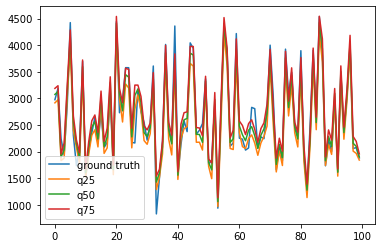

In [38]:
idxs = np.random.randint(0, y.shape[0], 100)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q25")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q75")
plt.legend(loc="best")
plt.show()

In [39]:
print(unc.min(), unc.mean(), unc.max(), (unc>=0).mean())

63.00537109375 258.10545399818045 466.3408203125 1.0


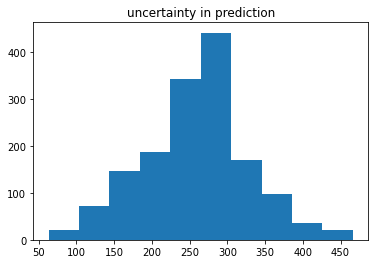

In [40]:
plt.hist(unc)
plt.title("uncertainty in prediction")
plt.show()

In [41]:
sub.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,WHERE,Confidence,Patient_Week,...,base_week,Male,Female,Ex-smoker,Never smoked,Currently smokes,age,BASE,week,percent
1540,ID00419637202311204720264,-12,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-12,...,-18.0,1,0,1,0,0,0.615385,0.3724,0.067901,0.332421
1541,ID00419637202311204720264,-11,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-11,...,-17.0,1,0,1,0,0,0.615385,0.3724,0.074074,0.332421
1542,ID00419637202311204720264,-10,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-10,...,-16.0,1,0,1,0,0,0.615385,0.3724,0.080247,0.332421
1543,ID00419637202311204720264,-9,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-9,...,-15.0,1,0,1,0,0,0.615385,0.3724,0.086420,0.332421
1544,ID00419637202311204720264,-8,3020,70.186855,73,Male,Ex-smoker,test,100.0,ID00419637202311204720264_-8,...,-14.0,1,0,1,0,0,0.615385,0.3724,0.092593,0.332421


In [42]:
# PREDICTION
sub['FVC1'] = 1.*pe[:, 1]
sub['Confidence1'] = pe[:, 2] - pe[:, 0]
subm = sub[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()
yo=subm.loc[~subm.FVC1.isnull()]
subm.loc[~subm.FVC1.isnull()].head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3020,100.0,3048.912476,211.405884
1541,ID00419637202311204720264_-11,3020,100.0,3044.759033,213.840698
1542,ID00419637202311204720264_-10,3020,100.0,3040.605591,216.275635
1543,ID00419637202311204720264_-9,3020,100.0,3036.452271,218.710449
1544,ID00419637202311204720264_-8,3020,100.0,3032.299072,221.145264


In [43]:
subm.loc[~subm.FVC1.isnull(),'FVC'] = subm.loc[~subm.FVC1.isnull(),'FVC1']
sigma_mean = 60
if sigma_mean<sigma_mean:
    subm['Confidence'] = sigma_opt
else:
    subm.loc[~subm.FVC1.isnull(),'Confidence'] = subm.loc[~subm.FVC1.isnull(),'Confidence1']

In [44]:
subm.head()

,Patient_Week,FVC,Confidence,FVC1,Confidence1
1540,ID00419637202311204720264_-12,3048.912476,211.405884,3048.912476,211.405884
1541,ID00419637202311204720264_-11,3044.759033,213.840698,3044.759033,213.840698
1542,ID00419637202311204720264_-10,3040.605591,216.275635,3040.605591,216.275635
1543,ID00419637202311204720264_-9,3036.452271,218.710449,3036.452271,218.710449
1544,ID00419637202311204720264_-8,3032.299072,221.145264,3032.299072,221.145264


In [45]:
subm.describe().T

,count,mean,std,min,25%,50%,75%,max
FVC,730.0,2609.399350,425.329001,1755.665222,2466.284271,2687.904785,2897.882568,3367.381470
Confidence,730.0,324.842263,64.329728,183.614258,280.876663,327.159546,381.595154,430.331299
FVC1,730.0,2609.399350,425.329001,1755.665222,2466.284271,2687.904785,2897.882568,3367.381470
Confidence1,730.0,324.842263,64.329728,183.614258,280.876663,327.159546,381.595154,430.331299


In [46]:
otest = pd.read_csv('../input/osic-pulmonary-fibrosis-progression/test.csv')
for i in range(len(otest)):
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    subm.loc[subm['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

In [47]:
subm[["Patient_Week","FVC","Confidence"]].to_csv("submission_regression.csv", index=False)

In [48]:
reg_sub = subm[["Patient_Week","FVC","Confidence"]].copy()

In [49]:
reg_sub

,Patient_Week,FVC,Confidence
1540,ID00419637202311204720264_-12,3048.912476,211.405884
1541,ID00419637202311204720264_-11,3044.759033,213.840698
1542,ID00419637202311204720264_-10,3040.605591,216.275635
1543,ID00419637202311204720264_-9,3036.452271,218.710449
1544,ID00419637202311204720264_-8,3032.299072,221.145264
...,...,...,...
2265,ID00426637202313170790466_129,2615.355957,395.397705
2266,ID00426637202313170790466_130,2614.581299,395.614990
2267,ID00426637202313170790466_131,2613.806763,395.832520
2268,ID00426637202313170790466_132,2613.032349,396.049805


# Ensemble (Simple Blend)

In [50]:
df1 = img_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
df2 = reg_sub.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

In [51]:
df1

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-1,3047.188081,97.374936
1,ID00419637202311204720264_-10,3082.144186,132.331041
2,ID00419637202311204720264_-11,3086.028198,136.215053
3,ID00419637202311204720264_-12,3089.912209,140.099064
4,ID00419637202311204720264_-2,3051.072093,101.258948
...,...,...,...
725,ID00426637202313170790466_95,2585.862509,410.962459
726,ID00426637202313170790466_96,2582.292641,414.532327
727,ID00426637202313170790466_97,2578.722772,418.102196
728,ID00426637202313170790466_98,2575.152904,421.672064


In [52]:
actual=yo[['Patient_Week','FVC']]

In [53]:
main=actual.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)

In [54]:
main

,Patient_Week,FVC
0,ID00419637202311204720264_-1,3020
1,ID00419637202311204720264_-10,3020
2,ID00419637202311204720264_-11,3020
3,ID00419637202311204720264_-12,3020
4,ID00419637202311204720264_-2,3020
...,...,...
725,ID00426637202313170790466_95,2925
726,ID00426637202313170790466_96,2925
727,ID00426637202313170790466_97,2925
728,ID00426637202313170790466_98,2925


In [55]:
df = df1[['Patient_Week']].copy()
df['FVC'] = (0.45*df1['FVC'] + 0.55*df2['FVC'])
df['Confidence'] = (0.45*df1['Confidence'] + 0.55*df2['Confidence'])
df

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_-1,3023.008440,174.822853
1,ID00419637202311204720264_-10,3059.297959,178.500568
2,ID00419637202311204720264_-11,3063.330157,178.909158
3,ID00419637202311204720264_-12,3067.362356,179.317815
4,ID00419637202311204720264_-2,3027.040706,175.231645
...,...,...,...
725,ID00426637202313170790466_95,2616.608619,398.316322
726,ID00426637202313170790466_96,2614.535027,400.061941
727,ID00426637202313170790466_97,2612.502591,401.787822
728,ID00426637202313170790466_98,2610.470156,403.513836


In [56]:
df.to_csv('submission.csv', index=False)

In [57]:
df.Confidence

0      174.822853
1      178.500568
2      178.909158
3      179.317815
4      175.231645
          ...    
725    398.316322
726    400.061941
727    401.787822
728    403.513836
729    405.239918
Name: Confidence, Length: 730, dtype: float64

In [58]:
def mainscore(actual_fvc, predicted_fvc, confidence, return_values = False):
    sd_clipped = np.maximum(confidence, 70)
    delta = np.minimum(np.abs(actual_fvc - predicted_fvc), 1000)
    metric = - np.sqrt(2) * delta / sd_clipped - np.log(np.sqrt(2) * sd_clipped)

    if return_values:
        return metric
    else:
        return np.mean(metric)


In [59]:
x=mainscore(main['FVC'],df['FVC'],df.Confidence)

In [60]:
x

-6.804301489324569